# Workshop 2: Using Computer Vision for Good! 🚀

- **When:** Wednesday, February 26th, 17:00.
- **Where:** Appleton Tower, 5.04. If you don't have access, reach out and we'll let you in!
- **Contacts:** Reach out on Instagram _@edinburgh.ai_
- **Credits:** This notebook is created by EdinburghAI for use in its workshops. If you plan to use it, please credit us!

## Today
- Today we're building a Sign Language Interpreter. 
- We'll take hundreds of photos of different hand signs and extract the relevant information.
- We'll try training different models.
- We'll then upload our own hand sign and see if our model accurately predicts it!

Lfg 🔥

# Setup:

## IMPORTANT! Turn On Internet
1. On the right-hand side of this notebook, there's a section called **"Session Options"**.
2. Scroll down to the _"Internet"_ toggle. Turn it on. You may need to verify your phone number.
3. Additionally, to help this run faster, you can also enable some GPU access.


## Using Jupyter:
This is a Jupyter notebook. It contains cells. There are 2 kinds of cells - markdown and Python. Markdown cells are like this one, and are just there to give you information. Python cells run code. You can run a cell with `Ctrl + Enter` or run a cell and move the next one with `Shift + Enter`. Try running the cell below.

In [2]:
print('Ctrl + Enter runs this cell!')
output = 'The last line of a cell is printed by default'
output

Ctrl + Enter runs this cell!


'The last line of a cell is printed by default'

In [3]:
# Installation
!pip install mediapipe
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # Progress bar
import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle  # For model saving & loading
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback  # Import progress bar for TensorFlow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

# Exploring Our Data

Like all good AI projects, we need to explore our data first. Check it out!

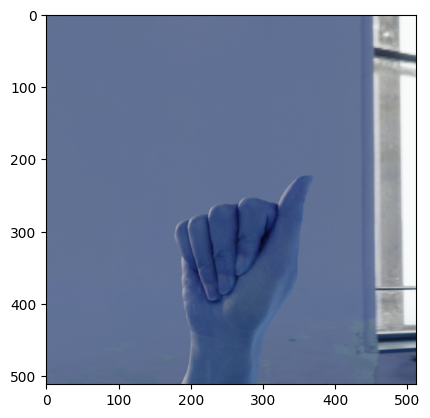

In [4]:
# We'll be using OpenCV for this project, a popular library for computer vision.
import cv2

# Let's load in an image and display it.
img = cv2.imread('/kaggle/input/synthetic-asl-alphabet/Train_Alphabet/A/0042513a-63c0-499f-a7f7-e6ee1266cb98.rgb_0000.png')
plt.imshow(img)

Hmmmm. That doesn't look quite right. Turns out OpenCV defaults to BlueGreenRed, but our eyes do not lol. 

🤔 _Why do you think that is?_ 

Regardless, let's convert the BGR image to an RGB image. 

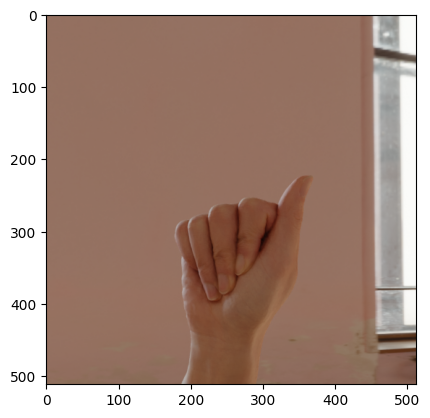

In [5]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### That's better 🤟! 

Ok sweet. Now that we have an idea of how the images look, we're going to use them to train two different models. 
- For the first model, we're going to take the crucial joints of the hand (wrist, phalanx etc. ✋) and feed _those_ into a _simple_ model.

- For the second, we're just going to say screw it and feed the entire image into a Convolutional Neural Network and pray. We'll not go into how it works today, but if you're curious, go to our [workshop](https://github.com/EdinburghAI/workshops/blob/main/Sem1Workshop3/CNNs-Solved.ipynb) from semester 1.


## Extracting Key Features of the Hand

#### Ok... How?
We're gonna use a library called _MediaPipe_ 👀. It's a suite of models designed for use in Computer Vision 🤖. We're going to use their _Hands_ model to segment the hands into its parts. If it detects there's hands in the photo, it'll place its parts as coordinates on top of the photo 🔎. 

Let's try it out!

_Stuck? There's some helpful demo's online. If you can't find them, try this [one](https://medium.com/@amineouahidialaoui/build-your-own-hand-detector-with-python-in-seconds-6c8ddb486d7d) 😉._

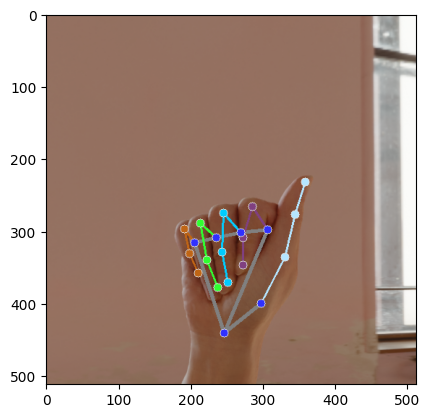

In [6]:
# We're going to use the hands library. 
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# We want to now initialise the Hands class. Keep in mind, 
# we'll using it on a static image (ie static_image_mode) 
# and will want to be reasonably confident (at least 30%)
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# Process the RGB photo
hand_landmarks = hands.process(img_rgb)

# We're going to iterate over each landmark and draw it.
for landmark in hand_landmarks.multi_hand_landmarks:

    # We could do with the drawing_utils' draw_landmarks function right about now.
    mp_drawing.draw_landmarks(
            img_rgb,  # image to on
            landmark,  # the landmarks for the hand
            mp_hands.HAND_CONNECTIONS,  # hand connections
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )

    plt.imshow(img_rgb)


### Reusability!
We're going to be loading an image, and turning it into a landmark a lot. Let's make it simpler by making it a function.

In [7]:
# Instantiate the Hands class
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

def take_image_path_and_return_landmarks(img_path):
    # Read the image
    img = cv2.imread(img_path)
    
    # Turn the image into RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process the landmarks 
    hand_landmarks = hands.process(img_rgb)
    
    return hand_landmarks

### Great. Now get those landmarks for every image.
Sweet! So we've found the landmarks of a single hand image using `mp.solutions.hands`. Now, let's do some Python to get that of every hand image.


#### Normalising
Take a look at the photo above. The coordinates are all roughly in the middle of the image. But what if all of the images of `B` were in the top left corner. The model might learn that if the coordinates are all in the top left corner, then it's `B` (👎). 

So how do we fix that? Well what if we subtract all of the coordinates by a certain amount, so they're always in the bottom left... This is called _normalisation_. 


In [8]:



# Where we're storing the data. If you've got any problems with it, try messing around with this part. 
DATA_DIR = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"

def turn_all_images_to_landmarks(DATA_DIR):
    
    data = []
    labels = []
    # We want to iterate over the entire training folder. 
    for dir_ in (os.listdir(DATA_DIR)):
        
        # Iterate over every single letter in each letter's folder. 
        # We're only going to take the 30 images, it's incredibly slow otherwise.
        for img_path in tqdm(os.listdir(os.path.join(DATA_DIR, dir_))[:30]):

            # We'll store our coordinates here, temporarily, as we normalise them.
            x_ = []
            y_ = []

            # Same as before...
            # Take image and return the landmark. If only we had a function for that.
            individual_photo_path = os.path.join(DATA_DIR, dir_, img_path)
            results = take_image_path_and_return_landmarks(individual_photo_path)

            
            # Check if there was a hand discovered in the first place.
            if results.multi_hand_landmarks:
                # Only take the first hand (our model doesn't know deal with 2 hands)
                hand_landmarks = results.multi_hand_landmarks[0]  
                
                # Take every x coordinate for every landmark
                x_ = [lm.x for lm in hand_landmarks.landmark]
                
                # Take every y coordinate for every landmark
                y_ = [lm.y for lm in hand_landmarks.landmark]
                
                data_aux = []
                for i in range(len(hand_landmarks.landmark)):
                    # This normalises them to be all centered at 0.
                    data_aux.append(x_[i] - min(x_))
                    data_aux.append(y_[i] - min(y_))
                data.append(data_aux)
                labels.append(dir_)

        print(f"Finished letter {dir_}")
    return labels, data
    


labels, data = turn_all_images_to_landmarks(DATA_DIR)

100%|██████████| 30/30 [00:01<00:00, 20.61it/s]


Finished letter N


100%|██████████| 30/30 [00:01<00:00, 20.83it/s]


Finished letter R


100%|██████████| 30/30 [00:01<00:00, 20.58it/s]


Finished letter B


100%|██████████| 30/30 [00:01<00:00, 22.27it/s]


Finished letter I


100%|██████████| 30/30 [00:01<00:00, 22.03it/s]


Finished letter F


100%|██████████| 30/30 [00:01<00:00, 22.75it/s]


Finished letter H


100%|██████████| 30/30 [00:01<00:00, 21.91it/s]


Finished letter E


100%|██████████| 30/30 [00:01<00:00, 23.19it/s]


Finished letter U


100%|██████████| 30/30 [00:01<00:00, 22.15it/s]


Finished letter M


100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


Finished letter X


100%|██████████| 30/30 [00:01<00:00, 22.32it/s]


Finished letter K


100%|██████████| 30/30 [00:01<00:00, 22.65it/s]


Finished letter Q


100%|██████████| 30/30 [00:01<00:00, 22.78it/s]


Finished letter Y


100%|██████████| 30/30 [00:00<00:00, 31.53it/s]


Finished letter Blank


100%|██████████| 30/30 [00:01<00:00, 22.84it/s]


Finished letter S


100%|██████████| 30/30 [00:01<00:00, 22.43it/s]


Finished letter G


100%|██████████| 30/30 [00:01<00:00, 22.87it/s]


Finished letter A


100%|██████████| 30/30 [00:01<00:00, 22.54it/s]


Finished letter O


100%|██████████| 30/30 [00:01<00:00, 22.81it/s]


Finished letter T


100%|██████████| 30/30 [00:01<00:00, 21.78it/s]


Finished letter V


100%|██████████| 30/30 [00:01<00:00, 22.68it/s]


Finished letter Z


100%|██████████| 30/30 [00:01<00:00, 20.95it/s]


Finished letter C


100%|██████████| 30/30 [00:01<00:00, 22.23it/s]


Finished letter P


100%|██████████| 30/30 [00:01<00:00, 22.13it/s]


Finished letter L


100%|██████████| 30/30 [00:01<00:00, 22.83it/s]


Finished letter W


100%|██████████| 30/30 [00:01<00:00, 22.12it/s]


Finished letter D


100%|██████████| 30/30 [00:01<00:00, 22.21it/s]

Finished letter J


Ummm. Did that work? Let's take a look at the what we made...

In [9]:
# Let's print out only the zeroeth data point and zeroeth label.
# Don't try print the entire thing. You'll crash your browser lol. There's a lot of floats.
data[0], labels[0]

([0.09061044454574585,
  0.31725040078163147,
  0.1752150058746338,
  0.24344322085380554,
  0.18338406085968018,
  0.14821657538414001,
  0.140508770942688,
  0.06963244080543518,
  0.09414792060852051,
  0.015058636665344238,
  0.15940189361572266,
  0.08862552046775818,
  0.20636039972305298,
  0.021530359983444214,
  0.2219322919845581,
  0.07056203484535217,
  0.21446490287780762,
  0.1307867467403412,
  0.11019730567932129,
  0.08817282319068909,
  0.15726733207702637,
  0.0,
  0.17823654413223267,
  0.06521716713905334,
  0.17859125137329102,
  0.13101544976234436,
  0.056918174028396606,
  0.0997186005115509,
  0.11374974250793457,
  0.06242445111274719,
  0.12903696298599243,
  0.1512814462184906,
  0.1176573634147644,
  0.2053956687450409,
  0.0,
  0.11673787236213684,
  0.0677594542503357,
  0.09705784916877747,
  0.07916086912155151,
  0.15491417050361633,
  0.06379973888397217,
  0.18607917428016663],
 'N')

### Sweet! That seems right...
Basically, they're a list of coordinates (normalised between 0-1), followed by the classification of the letter _"N"_. 

Now let's train a model. Let's use RandomForest. Don't forget to split the data into a corresponding train-test split and then get the accuracy. 

Why use not use a neural network? Well we'll get to that, always try the simplest solution first and build up from there. RandomForest is incredibly efficient. 

If all of that seems like non-sense, take a look at our first workshop we went [through in Sem1](https://github.com/EdinburghAI/workshops/blob/main/Sem1Workshop1/IntroToML/IntroToML-Solved.ipynb) - Scroll down to _"Decision Trees"_. 

In [10]:
# We'll split our data into a train-test  split. 
# This technically means we're not using the testing part of the dataset but fuck it we ball. 
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

# Create and train a RandomForestModel with sklearn (If unsure, check Sklearn RandomForests Docs - They're great!)
# Try different models as well! RandomForest isn't the one with the best performance 👀
model = RandomForestClassifier()
model.fit(x_train, y_train)

# Let's predict all of the the outputs for the x_testing set. 
y_predict = model.predict(x_test)

# Check the accuracy score for our predictions by comparing the y_predict to y_test. 
score = accuracy_score(y_predict, y_test)
print('{}% of samples were classified correctly!'.format(score * 100))

95.1048951048951% of samples were classified correctly!


### That was fast! 
The model trained reallyyyy quickly. In ML, you often don't have to pick the fanciest model. 

We're basically taking coordinates and trying to find a shape between them - therefore our model doesn't need to be the most complicated. This makes everything wayyy faster. 

### Inference Time
Now let's test it out! Take a photo on your phone of you doing a Sign and see if the model will recognise it!


To do this:
- Take a photo on your phone. Ensure there's only 1 hand visible in the frame.
- Pass the photo to your laptop.
- On the right hand side, scroll to the _"Upload"_ button > _"New Dataset"_ > File.
- Drag and drop your JPG file. 
- Give it a name
- Press create!
- Once loaded, copy the exact location of the file and paste it below

In [12]:
# -------------------------
# 🚀 Inference Function
# -------------------------
def infer_single_image_using_solution_1(img_path):
    """
    Takes an image path, extracts hand landmarks, and predicts the ASL letter using the trained model.
    """

    # Load and preprocess image. Again, a function would be convenient. 
    results = take_image_path_and_return_landmarks(img_path)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]  # Only take the first detected hand
        x_ = np.array([lm.x for lm in hand_landmarks.landmark])
        y_ = np.array([lm.y for lm in hand_landmarks.landmark])

        # ✅ Normalize features (same as training)
        x_min, y_min = x_.min(), y_.min()
        data_aux = np.column_stack((x_ - x_min, y_ - y_min)).flatten().tolist()

        # ✅ Predict using trained model
        prediction = model.predict([data_aux])[0]

        return prediction  # Return predicted label
    else:
        return "No hand detected!"


# -------------------------
# 🚀 Example Usage
# -------------------------
img_path = "/kaggle/input/another/IMG_4193.JPG"  # Replace with your actual test image
predicted_label = infer_single_image_using_solution_1(img_path)
print(f"Predicted ASL Letter: {predicted_label}")


Predicted ASL Letter: M


### Preparing for Solution 2 🧠:

Sweet! Well our solution 1 seems to work incredibly well. Let's try out solution 2. 

Solution 2 is _significantly_ more computationally expensive. I'd _highly_ recommend you pop on the GPU's if you want it to finish training for this workshop lol. 

Also, for the first solution, we only used ~1/3 of the data available, and we _still_ performed really well. Now, in order for solution 2 to do even half-way decent, we need *all* the data. This will take longer to prepare.

#### Preparing The Data

Aside from GPUs, we also need to change the images slightly so they'll fit into our CNN. For a refresher on CNNs, check out our [semester 1 workshop](https://github.com/EdinburghAI/workshops/blob/main/Sem1Workshop3/CNNs-Solved.ipynb) on them! _TLDR: They're neural networks that're specialised for images._

How're we going to standardise the data? We'll need to turn their colours to be between 0 and 1 (where each RGB is currently between 0-255). We'll also need to resize their pixels to be 128x128. 

Why for both? Well we're going to be feeding each pixel into the network. The model will perform better if the values are normalised to be between 0 and 1. 

And why resize to 128x128? Kind of arbitrary, but it's a smaller size (which allows it to train faster as there's less calculations). Also, the square shape makes the model architecture simpler. 

In [13]:
def utilise_gpus(): 
    # Check for available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ Using {len(gpus)} GPUs")
        for gpu in gpus:
            # Tell tensorflow to use the GPU's
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("❌ No GPU detected, training on CPU.")

utilise_gpus()

✅ Using 2 GPUs


In [20]:
# Load Data from Raw Images
def load_images(DATA_DIR, IMG_SIZE):
    
    data = []
    labels = []
    # Iterate over every image, make a dictionary that gives it its label.
    label_map = {label: idx for idx, label in enumerate(os.listdir(DATA_DIR))}

    for label in tqdm(os.listdir(DATA_DIR)):
        # Iteratve over every individual image
        for img_path in os.listdir(os.path.join(DATA_DIR, label)):
            # Take the image, turn it to RGB (like before) and resize it.
            img = cv2.imread(os.path.join(DATA_DIR, label, img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Add this image to our list
            data.append(img)
            labels.append(label_map[label])
    
    # Normalise colours from 0-255 to 0-1.
    data = np.array(data, dtype="float32") / 255.0  
    labels = np.array(labels)
    
    return data, labels



In [21]:
## Constants
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 64  # Adjustable based on GPU memory
EPOCHS = 10
DATA_DIR = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"

# Load dataset
data, labels = load_images(DATA_DIR, IMG_SIZE)

# How many different letters can we represent
num_classes = len(set(labels))
print(f"NUM CLASSES {num_classes}")

# Convert labels to one-hot encoding using Keras to_categorical.
labels = to_categorical(labels, num_classes)

# Split data into train and test sets (w)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

# Define the model to distribute the workload between GPUs.
with tf.distribute.MirroredStrategy().scope():
    
    # Define the model. Don't worry about the specifics for this workshop, they were discussed in the Sem1Workshop3
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile Model with multi-GPU strategy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model with Progress Bar
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,  # Hide default logs
                    callbacks=[TqdmCallback()])  # Show tqdm progress bar

# Evaluate Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 27/27 [07:29<00:00, 16.64s/it]


NUM CLASSES 27


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9844 - loss: 0.0736
✅ Test Accuracy: 98.44%


In [22]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Constants
IMG_SIZE = 128  # Must match training size
DATA_DIR = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"  # Update this with your actual dataset path


# Create label mapping (same as in training)
label_map = {label: idx for idx, label in enumerate(os.listdir(DATA_DIR))}
reverse_label_map = {idx: label for label, idx in label_map.items()}  # Reverse lookup

# -------------------------
# 🚀 Inference Function
# -------------------------
def infer_single_image_using_cnn(img_path):
    """
    Takes an image path, preprocesses it, and predicts the ASL letter using the trained CNN model.
    """
    # Load and preprocess image (same as before).
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to match training input size
    img = img.astype("float32") / 255.0  # Normalize pixel values

    # Expand dimensions to match CNN input shape (batch_size, height, width, channels)
    img = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model.predict(img)
    predicted_label_idx = np.argmax(predictions)  # Get index of highest probability

    # Map index back to ASL letter
    predicted_label = reverse_label_map[predicted_label_idx]
    
    return predicted_label  # Return predicted ASL letter


# -------------------------
# 🚀 Example Usage
# -------------------------
img_path = "/kaggle/input/another/IMG_4193.JPG"  # Replace with your test image path
predicted_label = infer_single_image_using_cnn(img_path)
print(f"Predicted ASL Letter: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predicted ASL Letter: E
